# Data Regrouping Example

As previously discussed, both estimators require enough observed failures for each (j, t). Sometimes, the data do not comply with this requirement. For example, when dealing with hospitalization length of stay, patients are more likely to be released after a few days rather than after a month, and releases can be less frequent on weekends.

In this example we demonstrate data regrouping that can be part of the preprocessing stage, which will allow a successful estimation. 

In [1]:
import warnings
import sys 

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
from pydts.examples_utils.plots import plot_events_occurrence, add_panel_text, plot_example_estimated_params
from pydts.fitters import TwoStagesFitter

pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 25)
warnings.filterwarnings('ignore')
%matplotlib inline

## Not enough observed failures in later times

We consider a setting in which the observed events become less frequent in later times by simply reducing the sample size to $n=1000$.

In [2]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

df = generate_quick_start_df(n_patients=1000, n_cov=5, d_times=30, j_events=2, pid_col='pid', seed=0, 
                             real_coef_dict=real_coef_dict)

Evidently, we see that we do not observe enough events in later times. For example, $n_{j=1,t=25} = 1$ and $n_{j=2,t=25} = 0$

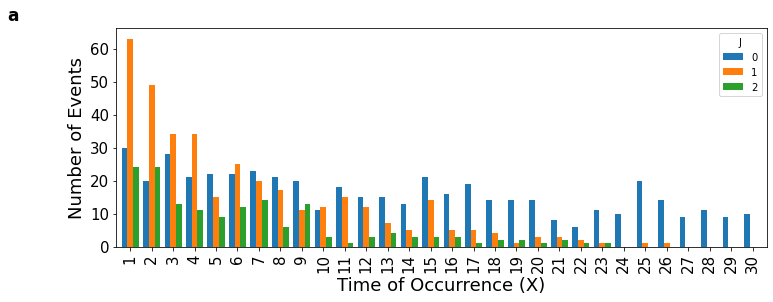

In [3]:
ax = plot_events_occurrence(df)
add_panel_text(ax, 'a')

Trying to fit the model with such data will result in the following error message:

In [4]:
m2 = TwoStagesFitter()
try:
    m2.fit(df.drop(columns=['C', 'T']), verbose=0)
except RuntimeError as e:
    raise e.with_traceback(None)

RuntimeError: Number of observed events at some time points are too small. Consider collapsing neighbor time points.
 See https://tomer1812.github.io/pydts/UsageExample-RegroupingData/ for more details.

For fixing zero events and the tail of the distribution, events occured later than the 21st day (either $J=1$ or $J=2$) are considered to be in a 21+ event time.

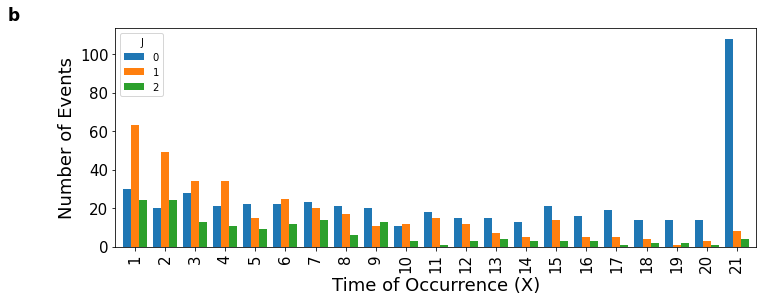

In [5]:
regrouped_df = df.copy()
regrouped_df['X'].clip(upper=21, inplace=True)
ax = plot_events_occurrence(regrouped_df)
add_panel_text(ax, 'b')

Now, we can successfully estimate the parameters:

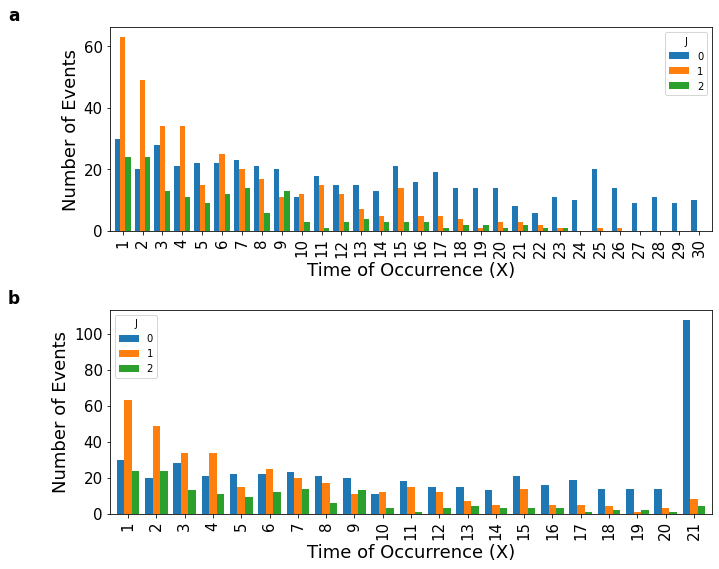

In [6]:
fig, axes = plt.subplots(2,1, figsize=(10,8))
ax = axes[0]
ax = plot_events_occurrence(df, ax=ax)
add_panel_text(ax, 'a')
ax = axes[1]
ax = plot_events_occurrence(regrouped_df, ax=ax)
add_panel_text(ax, 'b')
fig.tight_layout()

In [7]:
m2 = TwoStagesFitter()
m2.fit(regrouped_df.drop(columns=['C', 'T']))

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


{1: [<lifelines.CoxPHFitter: fitted with 9091 total observations, 8732 right-censored observations>,
      J   X  n_jt                                            opt_res  success  \
  21  1   1    63  {'fun': 7.899865296819892e-10, 'jac': [3.25276...     True   
  22  1   2    49  {'fun': 6.672771377754996e-09, 'jac': [8.42192...     True   
  23  1   3    34  {'fun': 9.139255069833103e-10, 'jac': [2.45757...     True   
  24  1   4    34  {'fun': 1.0671538826204064e-10, 'jac': [9.2225...     True   
  25  1   5    15  {'fun': 2.6553023893234515e-08, 'jac': [7.3555...     True   
  26  1   6    25  {'fun': 1.36255331556433e-09, 'jac': [2.899475...     True   
  27  1   7    20  {'fun': 8.274494805238853e-09, 'jac': [6.38844...     True   
  28  1   8    17  {'fun': 1.6826575532769916e-08, 'jac': [8.6823...     True   
  29  1   9    11  {'fun': 8.942147495124666e-09, 'jac': [4.56309...     True   
  30  1  10    12  {'fun': 3.6416509025721387e-10, 'jac': [1.1041...     True   
  31  1 

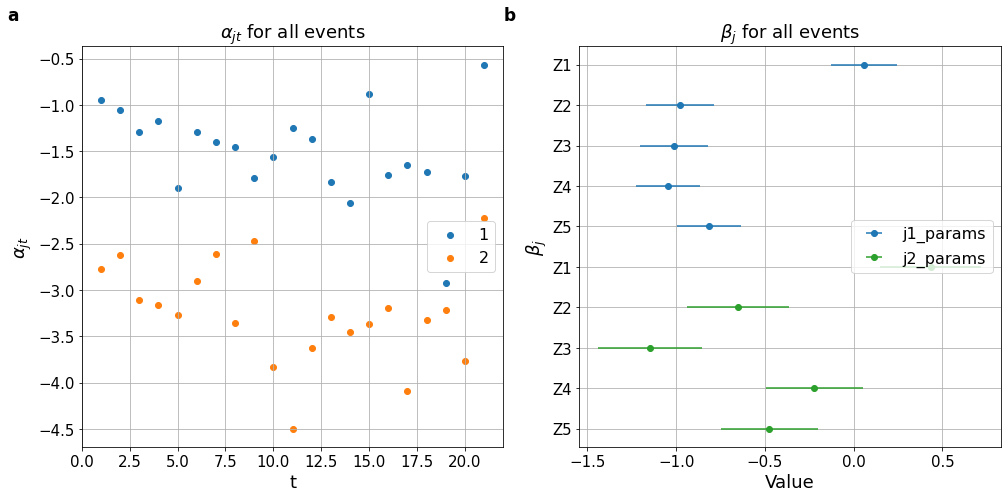

In [8]:
plot_example_estimated_params(m2)

In [9]:
m2.print_summary()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.059593,0.187268,0.433584,0.286376
Z2,-0.977635,0.192579,-0.651536,0.285630
Z3,-1.012224,0.191226,-1.147630,0.290300
Z4,-1.048233,0.180891,-0.221056,0.272420
Z5,-0.817598,0.180479,-0.475688,0.272666




Model summary for event: 1


n_jt  success  alpha_jt
J X                          
1 1     63     True -0.947684
  2     49     True -1.051086
  3     34     True -1.295866
  4     34     True -1.178560
  5     15     True -1.903136
  6     25     True -1.298924
  7     20     True -1.401847
  8     17     True -1.451159
  9     11     True -1.788478
  10    12     True -1.564731
  11    15     True -1.247966
  12    12     True -1.373390
  13     7     True -1.834668
  14     5     True -2.060652
  15    14     True -0.884086
  16     5     True -1.761146
  17     5     True -1.645269
  18     4     True -1.729781
  19     1     True -2.928615
  20     3     True -1.769298
  21     8     True -0.566276



Model summary for event: 2


n_jt  success  alpha_jt
J X                          
2 1     24     True -2.770174
  2     24     True -2.619309
  3     13     True -3.105049
  4     11     True -3.164241
  5      9     True -3.269706
  6     12     True -2.900518
  7     14     True -2.616379
  8      6     True -3.361561
  9     13     True -2.468053
  10     3     True -3.827000
  11     1     True -4.497481
  12     3     True -3.627228
  13     4     True -3.288580
  14     3     True -3.455462
  15     3     True -3.369194
  16     3     True -3.193872
  17     1     True -4.094674
  18     2     True -3.325382
  19     2     True -3.218786
  20     1     True -3.768195
  21     4     True -2.222326

## Not enough observed events at specific times

Consider the case of no events during the weekends. In the following we resample the data to reflect this setting:

In [10]:
def map_days(row):
    if row['X'] in [7, 14, 21] and row['J'] in [1,2]:
        row['X'] -= 1
        row['X'].astype(int)
    return row

regrouped_df = regrouped_df.apply(map_days, axis=1)
regrouped_df[['J', 'T', 'C', 'X']] = regrouped_df[['J', 'T', 'C', 'X']].astype('int64')
(regrouped_df.groupby(['J'])['X'].value_counts()).to_frame().unstack()

X                                                                    \
X    1     2     3     4     5     6     7     8     9     10    11    12   
J                                                                           
0  30.0  20.0  28.0  21.0  22.0  22.0  23.0  21.0  20.0  11.0  18.0  15.0   
1  63.0  49.0  34.0  34.0  15.0  45.0   NaN  17.0  11.0  12.0  15.0  12.0   
2  24.0  24.0  13.0  11.0   9.0  26.0   NaN   6.0  13.0   3.0   1.0   3.0   

                                                          
X    13    14    15    16    17    18    19    20     21  
J                                                         
0  15.0  13.0  21.0  16.0  19.0  14.0  14.0  14.0  108.0  
1  12.0   NaN  14.0   5.0   5.0   4.0   1.0  11.0    NaN  
2   7.0   NaN   3.0   3.0   1.0   2.0   2.0   5.0    NaN

<AxesSubplot:xlabel='Time of Occurrence (X)', ylabel='Number of Events'>

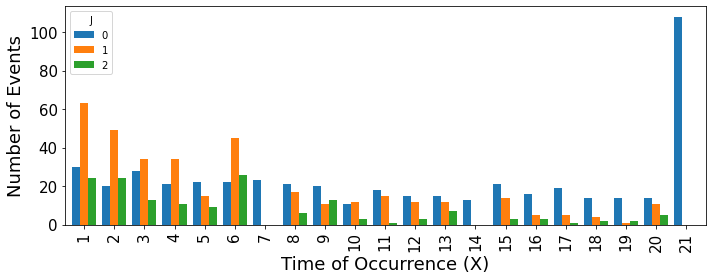

In [11]:
df = regrouped_df.copy()
plot_events_occurrence(regrouped_df)

Trying to fit the model with such data will result in the following error message:

In [12]:
m2 = TwoStagesFitter()
try: 
    m2.fit(regrouped_df.drop(columns=['C', 'T']), verbose=0)
except RuntimeError as e:
    raise e.with_traceback(None)

RuntimeError: Number of observed events at some time points are too small. Consider collapsing neighbor time points.
 See https://tomer1812.github.io/pydts/UsageExample-RegroupingData/ for more details.

We suggest to regroup empty times with the preceding days:

In [13]:
def map_days_second_try(row):
    if row['X'] in [7, 14, 21] and row['J'] == 0:
        row['X'] -= 1
        row['X'].astype(int)
    return row

regrouped_df = regrouped_df.apply(map_days_second_try, axis=1)
regrouped_df[['J', 'T', 'C', 'X']] = regrouped_df[['J', 'T', 'C', 'X']].astype('int64')
(regrouped_df.groupby(['J'])['X'].value_counts()).to_frame().unstack()

X                                                                     
X  1   2   3   4   5   6   8   9   10  11  12  13  15  16  17  18  19   20
J                                                                         
0  30  20  28  21  22  45  21  20  11  18  15  28  21  16  19  14  14  122
1  63  49  34  34  15  45  17  11  12  15  12  12  14   5   5   4   1   11
2  24  24  13  11   9  26   6  13   3   1   3   7   3   3   1   2   2    5

<AxesSubplot:xlabel='Time of Occurrence (X)', ylabel='Number of Events'>

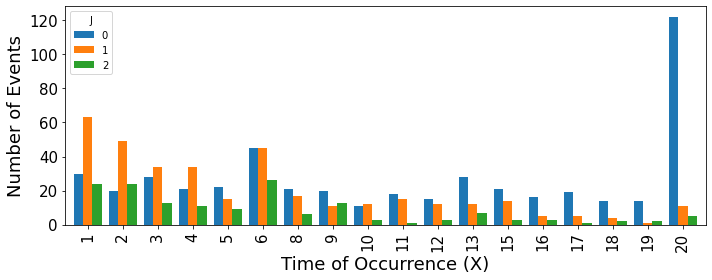

In [14]:
plot_events_occurrence(regrouped_df)

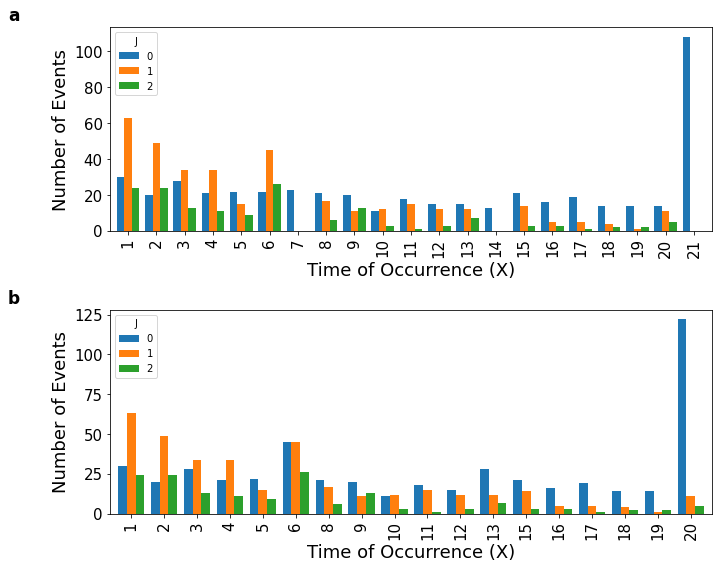

In [15]:
fig, axes = plt.subplots(2,1, figsize=(10,8))
ax = axes[0]
ax = plot_events_occurrence(df, ax=ax)
add_panel_text(ax, 'a')
ax = axes[1]
ax = plot_events_occurrence(regrouped_df, ax=ax)
add_panel_text(ax, 'b')
fig.tight_layout()

Now, we can estimate the parameters, while the interpretation of the parameters related to the grouped time points should be interpreted with care.

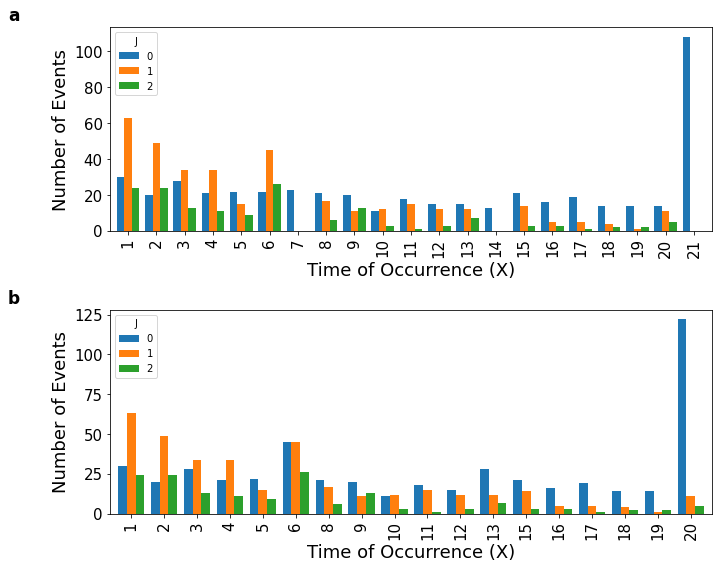

In [16]:
fig, axes = plt.subplots(2,1, figsize=(10,8))
ax = axes[0]
ax = plot_events_occurrence(df, ax=ax)
add_panel_text(ax, 'a')
ax = axes[1]
ax = plot_events_occurrence(regrouped_df, ax=ax)
add_panel_text(ax, 'b')
fig.tight_layout()

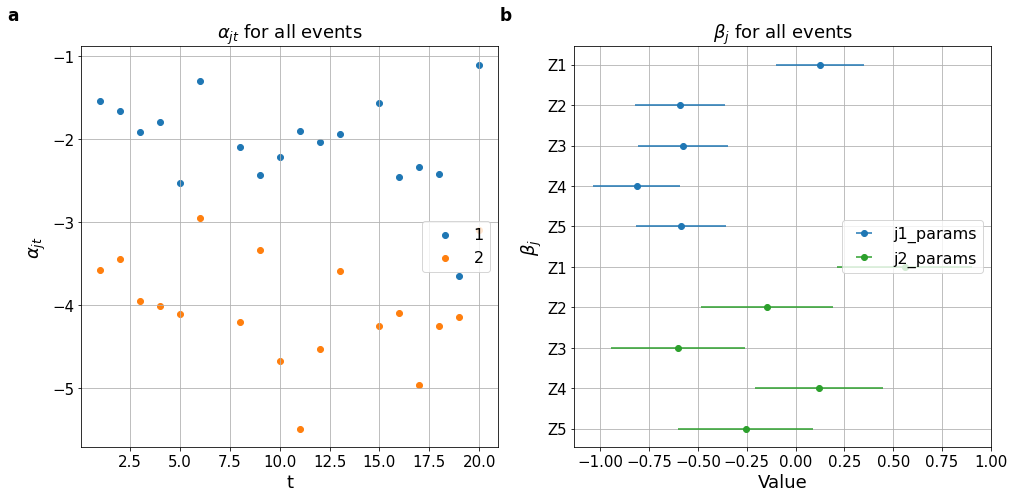

In [17]:
m2 = TwoStagesFitter()
m2.fit(regrouped_df.drop(columns=['C', 'T']), verbose=0)
plot_example_estimated_params(m2)

In [18]:
m2.print_summary()

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.125497,0.226571,0.559011,0.344835
Z2,-0.590350,0.230030,-0.146264,0.338669
Z3,-0.577012,0.230431,-0.601869,0.343531
Z4,-0.813756,0.221557,0.119530,0.328842
Z5,-0.586253,0.231495,-0.254760,0.345008




Model summary for event: 1


n_jt  success  alpha_jt
J X                          
1 1     63     True -1.544779
  2     49     True -1.658131
  3     34     True -1.911357
  4     34     True -1.795520
  5     15     True -2.530238
  6     45     True -1.296992
  8     17     True -2.090432
  9     11     True -2.431846
  10    12     True -2.211441
  11    15     True -1.904531
  12    12     True -2.032937
  13    12     True -1.938316
  15    14     True -1.565972
  16     5     True -2.453997
  17     5     True -2.335441
  18     4     True -2.424637
  19     1     True -3.647561
  20    11     True -1.103130



Model summary for event: 2


n_jt  success  alpha_jt
J X                          
2 1     24     True -3.574037
  2     24     True -3.442172
  3     13     True -3.946532
  4     11     True -4.010704
  5      9     True -4.104630
  6     26     True -2.947698
  8      6     True -4.205070
  9     13     True -3.331808
  10     3     True -4.678181
  11     1     True -5.489276
  12     3     True -4.531819
  13     7     True -3.595795
  15     3     True -4.254731
  16     3     True -4.099612
  17     1     True -4.963138
  18     2     True -4.249112
  19     2     True -4.146457
  20     5     True -3.099039